<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
import spacy
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
import string
import datetime
from collections import Counter

#nlp = spacy.load("en_core_web_lg")
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Let's call all the functions
pd.set_option('display.max_colwidth', 100)
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
# NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages.
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to /Users/Shu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Modelling

In [4]:
zoom_team = pd.read_csv('zoom_team.csv', low_memory=False)

In [5]:
zoom_team.shape

(15033, 10)

In [7]:
X = zoom_team['lemmatized']
y = zoom_team['target']

In [8]:
# Define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42) 

In [9]:
X_train.head()

13573    when ever i click on the link for the stream in onenote it open but say there s a problem with t...
4209     hello zoom community i am a teacher and i have four discrete period of high school student that ...
12896    anyone here with experience on hashing out a mtr system so it predictably work in a domain it a ...
6244     so i am a mac user and my music quality drop whenever i join a call i am using wireless earphone...
10633    ha anybody gotten this yet i really want to try out adding my personal account and family but i ...
Name: lemmatized, dtype: object

In [10]:
# Checking my baseline model. 60% of the train set is zoom. 
y_train.value_counts(normalize=True)

1    0.600114
0    0.399886
Name: target, dtype: float64

In [11]:
# if we use a random prediction algoritm as baseline
Random_prediction_algorithm = round(((0.600114 * 0.600114) + (0.399886 * 0.399886)) * 100, 2)
print(f'The random prediction algorithm will return {Random_prediction_algorithm}%.')

The random prediction algorithm will return 52.0%.


In [12]:
X_test.head()

564     after the actualization of the app i started having problem with remote control function when i ...
4327    so i have been using this software for a few week and i m encountering a problem regarding scree...
9253    i ran into a strange issue with on of my team user at the end of last week that i m hoping that ...
1211                                                                                              pleaseeee
1125    doe anyone know is there any software service that provides closed caption in spanish for zoom m...
Name: lemmatized, dtype: object

In [13]:
# Checking my baseline model. 60% of the test set is zoom. 
y_test.value_counts(normalize=True)

1    0.6
0    0.4
Name: target, dtype: float64

By guessing zoom at every try, any model will be right 60% of the time. So, the final model score ought be above 52% accurate for both classes.

In [15]:
# Creating a pipeline that processes with TfidVectorizer and models with LogisticRegression, and running Gridsearch, so that i get the scores and best params
pipe_tvec_lr = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('lr',LogisticRegression(solver='liblinear'))])
pipe_tvec_lr_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':[None,'english'],
                       'tvec__ngram_range': [(1,1),(1,2),(1,3)],
                       'lr__penalty':['l1','l2'],
                       'lr__C':[0.01,0.1,1]}

gs_tvec_lr = GridSearchCV(pipe_tvec_lr,pipe_tvec_lr_params,cv=5)
gs_tvec_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(strip_accents='unicode')),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lr__C': [0.01, 0.1, 1], 'lr__penalty': ['l1', 'l2'],
                         'tvec__max_features': [None, 1000, 2000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tvec__stop_words': [None, 'english']})

In [16]:
# Training score
print('train score: ', gs_tvec_lr.score(X_train, y_train))

# Test score
print('test score: ', gs_tvec_lr.score(X_test, y_test))

train score:  0.9703506604580443
test score:  0.9337028824833703


Test score is high but not overfitted. 

In [17]:
# Get predictions
preds = gs_tvec_lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [18]:
print(confusion_matrix(y_test,preds))
print('\n')
print(classification_report(y_test,preds))

[[1570  234]
 [  65 2641]]


              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1804
           1       0.92      0.98      0.95      2706

    accuracy                           0.93      4510
   macro avg       0.94      0.92      0.93      4510
weighted avg       0.94      0.93      0.93      4510



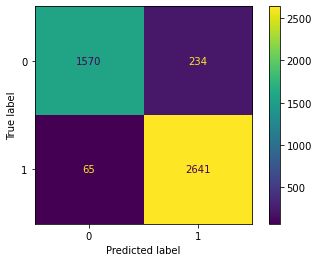

In [193]:
# View confusion matrix
plot_confusion_matrix(gs_tvec_lr, X_test, y_test);

Accuracy is high, but model seems to err on the side of classifying text as zoom when it is teams. Train scores tend to overfit.

In [33]:
# Creating a pipeline that processes with TfidVectorizer and models with RandomForestClassifier
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [32]:
pipe_tvec_forest = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('rf',RandomForestClassifier())])
pipe_tvec_forest_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':['english'],
                       'tvec__ngram_range': [(1,3)],
                       'rf__max_features':['auto', 'sqrt'],
                       'rf__bootstrap':[True, False]}

gs_tvec_forest = GridSearchCV(pipe_tvec_forest,pipe_tvec_forest_params,cv=3)
gs_tvec_forest.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(strip_accents='unicode')),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__bootstrap': [True, False],
                         'rf__max_features': ['auto', 'sqrt'],
                         'tvec__max_features': [None, 1000, 2000],
                         'tvec__ngram_range': [(1, 3)],
                         'tvec__stop_words': ['english']})

In [34]:
# Training score
print('train score: ', gs_tvec_forest.score(X_train, y_train))

# Test score
print('test score: ', gs_tvec_forest.score(X_test, y_test))

train score:  0.9980994013114131
test score:  0.9334811529933481


In [36]:
# Get predictions
preds = gs_tvec_forest.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [37]:
print(confusion_matrix(y_test,preds))
print('\n')
print(classification_report(y_test,preds))

[[1586  218]
 [  82 2624]]


              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1804
           1       0.92      0.97      0.95      2706

    accuracy                           0.93      4510
   macro avg       0.94      0.92      0.93      4510
weighted avg       0.93      0.93      0.93      4510



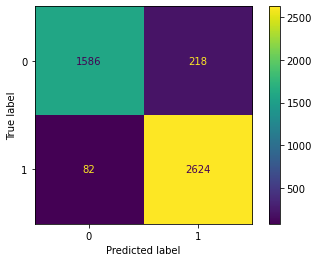

In [194]:
# View confusion matrix

plot_confusion_matrix(gs_tvec_forest, X_test, y_test);

Again, accuracy is high, but this model seems to err on the side of classifying text as teams when it is zoom. 

In [30]:
# Creating a pipeline that processes with TfidVectorizer and models with Multinomial Naive Bayes

MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [39]:
pipe_tvec_mnNB = Pipeline([('tvec',TfidfVectorizer(strip_accents='unicode')),('mnNB', MultinomialNB())])
pipe_tvec_mnNB_params = {'tvec__max_features':[None,1000,2000],
                       'tvec__stop_words':['english'],
                       'tvec__ngram_range': [(1,3)],
                       'mnNB__alpha':np.linspace(0.5, 1.5, 6)
                        }

gs_tvec_mnNB = GridSearchCV(pipe_tvec_mnNB,pipe_tvec_mnNB_params,verbose=0,cv=3)
gs_tvec_mnNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(strip_accents='unicode')),
                                       ('mnNB', MultinomialNB())]),
             param_grid={'mnNB__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'tvec__max_features': [None, 1000, 2000],
                         'tvec__ngram_range': [(1, 3)],
                         'tvec__stop_words': ['english']})

In [40]:
# Training score
print('train score: ', gs_tvec_mnNB.score(X_train, y_train))

# Test score
print('test score: ', gs_tvec_mnNB.score(X_test, y_test))

train score:  0.9187494060629098
test score:  0.9011086474501109


Still another great model, with the train and test scores close to each other without underfitting. 

In [196]:
# Get predictions
preds = gs_tvec_mnNB.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [197]:
print(confusion_matrix(y_test,preds))
print('\n')
print(classification_report(y_test,preds))

[[1477  327]
 [ 119 2587]]


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1804
           1       0.89      0.96      0.92      2706

    accuracy                           0.90      4510
   macro avg       0.91      0.89      0.89      4510
weighted avg       0.90      0.90      0.90      4510



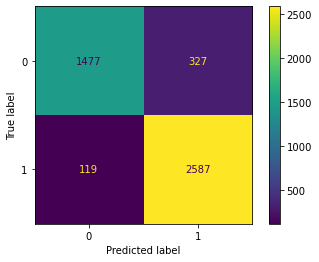

In [198]:
# View confusion matrix

plot_confusion_matrix(gs_tvec_mnNB, X_test, y_test);

In [44]:
# Selecting TfidVectorizer and LogisticRegression to creat final model
print(gs_tvec_lr.best_score_)

0.9375659980311226


In [47]:
gs_tvec_lr.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                                 strip_accents='unicode')),
                ('lr', LogisticRegression(C=1, solver='liblinear'))])

In [48]:
gs_tvec_lr.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_features': None,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': 'english'}

In [54]:
final_tvec = TfidfVectorizer(max_features= None, ngram_range=(1,3), stop_words='english')

X_train_transformed = final_tvec.fit_transform(X_train)

X_test_transformed = final_tvec.transform(X_test)

final_lr = LogisticRegression(C=1, penalty='l2')

final_lr.fit(X_train_transformed, y_train)

print(f'Final training score: {final_lr.score(X_train_transformed, y_train)}')
print(f'Final test score: {final_lr.score(X_test_transformed, y_test)}')

Final training score: 0.9703506604580443
Final test score: 0.9337028824833703


final scores and identical to initial. The default params of the model were the best.

earlier train score:  0.9703506604580443 .

earlier test score:  0.9337028824833703 .

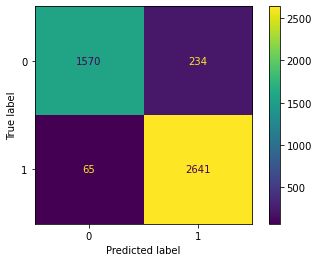

In [70]:
plot_confusion_matrix(final_lr, X_test_transformed, y_test);

In [74]:
df_proba = pd.DataFrame(final_lr.predict_proba(X_test_transformed), columns=['Team', 'Zoom'])
df_proba_team = df_proba['Team']
df_proba_zoom = df_proba['Zoom']

print(f'In predicting Team, it is on average {round(100*df_proba_team[df_proba_team >= 0.5].mean())}% confident')
print(f'In predicting Zoom, it is on average {round(100*df_proba_zoom[df_proba_zoom >= 0.5].mean())}% confident')

In predicting Team, it is on average 86% confident
In predicting Zoom, it is on average 85% confident


In [103]:
y_pred = final_lr.predict(X_test_transformed)

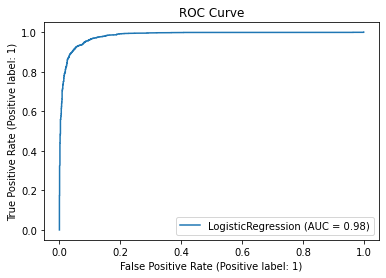

In [105]:
plot_roc_curve(final_lr, X_test_transformed, y_test)
plt.title('ROC Curve');

In [55]:
X_train_transformed.shape

(10523, 467436)

In [56]:
X_train_transformed

<10523x467436 sparse matrix of type '<class 'numpy.float64'>'
	with 826177 stored elements in Compressed Sparse Row format>

In [75]:
# placing the X_train_transformed into a matrix to get coeff
df_X_train_transformed = pd.DataFrame(X_train_transformed.todense(), columns=final_tvec.get_feature_names())
df_X_train_transformed.head()

,00,00 00,00 00 00,00 00 000,00 00 camera,00 00 clock,00 00 coworker,00 00 followup,00 00 instead,00 00 launch,00 00 look,00 00 number,00 00 person,00 00 pm,00 00 recent,00 00 register,00 00 thanks,00 00 viewer,00 00 workd,00 000,00 000 000,00 000 access,00 000 amke,00 000 moment,00 000 participant,00 000 row,00 000 user,00 000 view,00 000 way,00 0000,00 0000 user,00 00mbps,00 00mbps internet,00 09,00 09 00,00 09 auth,00 09 brow,00 09 cfg,00 09 rssvc,00 09 sip,00 09 spend,00 09 wad,00 0c0d,00 0c0d gcid,00 0c0d sip,00 0x,00 0x use,00 90,00 90 auto,00 90 missing,00 900,00 900 similar,00 999,00 999 amp,00 99d,00 99d scenarioname,00 9xxx,00 9xxx version,00 abandon,00 abandon connected,00 abandon listen,00 able,00 able wt,00 account,00 account domain,00 account limited,00 actually,00 actually new,00 af,00 af core,00 amazon,00 amazon gift,00 amid,00 amid european,00 amp,00 amp 00b,00 amp nbsp,00 android,00 android update,00 annual,00 annual phone,00 anybody,00 anybody seen,00 application,00 application android,00 appphonelockc,00 appphonelockc init,00 arrived,00 arrived appears,00 attendee,00 attendee 00,00 attendee main,00 attendee meeting,00 attendee need,00 attendee panelist,00 attendee popped,00 attendee right,00 attendee sign,00 attendee speaker,00 attendee team,00 attendee want,00 attendee webinars,00 attending,00 attending ve,00 audio,00 audio conference,00 audiocodes,00 audiocodes 0hd,00 auth,00 auth state,00 authsvc,00 authsvc soauth,00 available,00 available checking,00 available laptop,00 bad,00 bad request,00 barely,00 barely hear,00 basic,00 basic thing,00 bit,00 bit amp,00 bit doesn,00 bit le,00 bit linux,00 bit pressing,00 bit problem,00 bit team,00 bit uninstalled,00 bit used,00 bit way,00 bit work,00 block,00 block 9th,00 blue,00 blue yeti,00 bluetooth,00 bluetooth headset,00 boston,00 boston suburb,00 brain,00 brain setup,00 breaking,00 breaking bank,00 breakout,00 breakout room,00 bug,00 bug fixed,00 bug missing,00 bug team,00 build,00 build 90,00 buy,00 buy 00,00 camera,00 camera enabled,00 capacity,00 capacity limit,00 case,00 case doe,00 cauthsvcupdatetokennotifier,00 cauthsvcupdatetokennotifier usermode,00 ccx,00 ccx 00,00 central,00 central european,00 certain,00 certain laptop,00 certain using,00 certification,00 certification exam,00 changed,00 changed sunday,00 channel,00 channel limit,00 channel team,00 cheap,00 cheap laptop,00 check,00 check line,00 clarity,00 clarity issue,00 class,00 class school,00 clock,00 clock hour,00 close,00 close blue,00 code,00 code eastern,00 code host,00 compatibility,00 compatibility probably,00 concurrent,00 concurrent job,00 condenser,00 condenser blue,00 configured,00 configured work,00 connected,00 connected pc,00 core,00 core processor,00 coworker,00 coworker ha,00 cproxyservice,00 cproxyservice general,00 cpu,00 cpu usage,00 creating,00 creating team,00 csegetucrsp,00 csegetucrsp execute,00 cst,00 curlretcode,00 curlretcode retval,00 cweblayoutmgr,00 cweblayoutmgr handleproxyconfiguration,00 dated,00 dated feb,00 desk,00 desk phone,00 desktop,00 desktop phone,00 device,00 device currently,00 device versus,00 digital,00 digital coronavirus,00 digital signature,00 direct,00 direct operator,00 dodnslistlookup,00 dodnslistlookup tcp,00 dodnslistlookup tl,00 doe,00 doe mean,00 doesn,00 doesn affected,00 doesn experience,00 doesn proxy,00 don,00 don option,00 don proxy,00 dual,00 dual screen,00 dumb,00 dumb make,00 easily,...,zoombomb,zoombomb class,zoombomb invite,zoombomb lonely,zoombomb lonely friend,zoombombed,zoombomber,zoombomber continued,zoombomber continued scream,zoombomber traced,zoombomber traced police,zoombombing,zoombombing concern,zoombombing concern using,zoombombing help,zoombombing issue,zoombombing issue colleague,zoombombing issue college,zoombombing just,zoombombing just want,zoombombing live,zoombombing log,zoombombing log pls,zoombombing needed,zoombombing product,zoombombing product poor,zoombombing webside,zoombombing webside zoom,zoombombings,zoomb

In [92]:
# create new dataframe with 2 columns: feature, which is the column names and the corresponding coefficient generated by the logreg model
df_coef = pd.DataFrame({'feature': df_X_train_transformed.columns,
                        'coefficient': final_lr.coef_[0]})

# sort dataframe by size of coefficient so that we can take the largest 20 and smallest 20
df_coef = df_coef.sort_values('coefficient', ascending=False)

df_coef.head()

,feature,coefficient
459453,zoom,20.952259
168945,host,6.450555
463290,zoom meeting,3.589600
64188,class,3.017504
270913,participant,2.776297


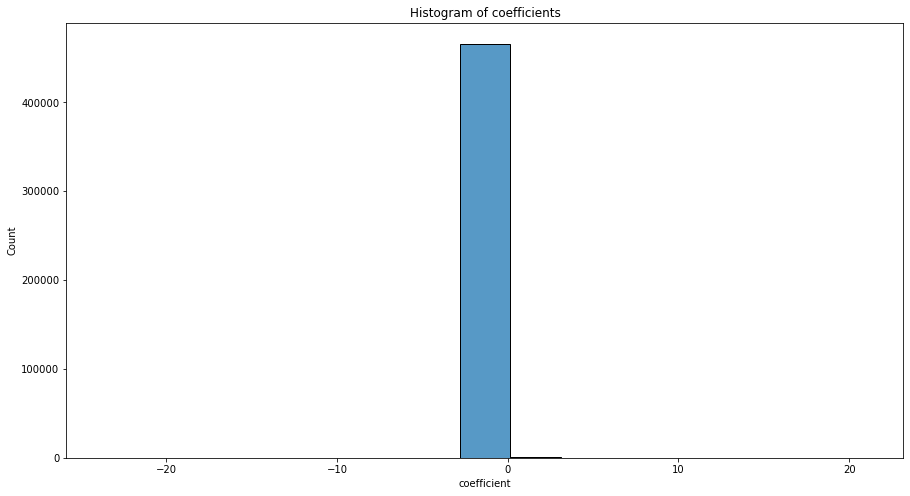

In [96]:
plt.figure(figsize=(15,8))
sns.histplot(data=df_coef, x='coefficient', bins=15)
plt.title('Histogram of coefficients');

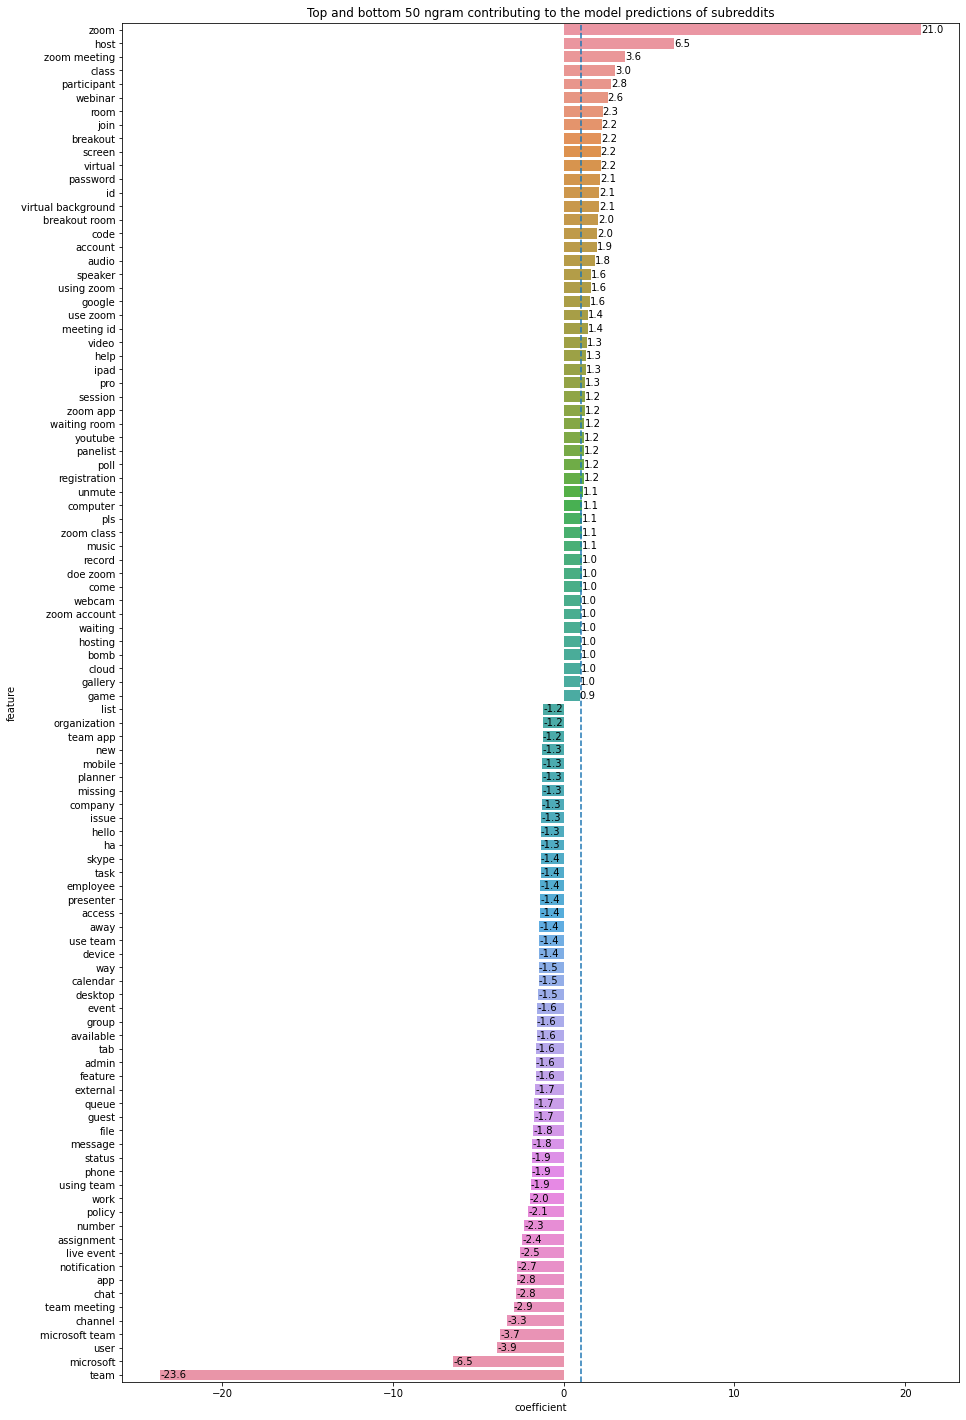

In [201]:
plt.figure(figsize=(15,25))

ax = sns.barplot(data=pd.concat([df_coef.head(50), df_coef.tail(50)]), y='feature', x='coefficient')

ax.set_title('Top and bottom 50 ngram contributing to the model predictions of subreddits')

# draw a dotted line at x=1, above this line, model will tend to predict class 1 (Zoom)
# below this line, model will tend to predict class 0 (MST)
plt.axvline(x=1, ls='--')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 0,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.1f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

#### Interpret your model

The coefficients of LogisticRegression measure the degree which the target variable is sensitive to the feature. A larger absolute value of the coefficients implies that the target is more sensitive toward that feature.

From the above graph, we see that the word "zoom" has the largest coefficient while "team" has the largest negative coefficient. In the context of our problem, success is defined by classifying the submission as a Zoom subreddit, and is arbitrarily set. Ie. Success could also be defined as MicrosoftTeams and the result would be the same. 

Because of the exponent, we say that features with a coefficient larger than 1 will improve the odds of the model predicting Zoom, and features with coefficients less than 1 will improve the odds of the model predicting MST. The blue dotted line depicts this cut off. Interestingly, out of the 16000 features, only 19 of them, when present, increases the odds of success.

The coefficients imply that the 2 words "team" and "zoom" are extremely important.

In [184]:
#Examining some of the ngrams with higher coeff. Looking at the last 3-5 posts to get a sense of what is being said. 
#To see if there are pain points to pick up on
#I've chosen zoom_meetings, join, code, audio for zoom & microsoft_team and chat for teams. 

Zoom_meeting_examples = []

for i in X_train:
    if 'zoom meeting' in i:
        Zoom_meeting_examples.append(i)
    
print(Zoom_meeting_examples[-3:])

['due to the obvious high demand for video it ha grown in popularity any company or job ha migrated to the online world a a result of digitization video conferencing is often the right option for attending a business meeting or speaking with your loved one video conference are not only easy but they also come at no cost to hold a successful video conference all you need is a decent wifi connection and a good laptop or another electronic device a good webcam microphone and speaker are needed for video conference following are the best laptop for zoom meeting dell inspiron acer chromebook r microsoft surface laptop apple macbook air amp x 00b best laptop for zoom which you should buy', 'good afternoon i am preparing to zoom our in person meeting 0 people to anyone who want to join u online i have one victim er member interested so far we are using the free 0 minute limit zoom account a we have no budget for this i am using my own personal pc notebook lenovo z 0 my first thought wa to pur

In [186]:
join_examples = []

for i in X_train:
    if 'join' in i:
        join_examples.append(i)
    
print(join_examples[-5:])

['i m having a zoom class this coming monday which requires u to have a camera whatever the reasoning behind that may be now i do have a modern desktop pc with a studio quality sound setup but no webcam can i use my phone a a webcam exclusively while using my pc a the main machine to attend the class and talk with the other student i do know that i can join a class with a pc and a phone at the same time but i haven t found an answer to my exact use case thanks for the help using two device at the same time', 'when a meeting start i get a pop up alert asking to join the meeting but sometimes i might not be present when the meeting start and later when i open my laptop i want to actually see if the meeting is started or not by somebody is there any way to do it in team without clicking the join button i don t want to click the join button because if the meeting is not started then i might be the one starting it which might be awkward how do i tell if a meeting is started or not in team',

In [187]:
code_examples = []

for i in X_train:
    if 'code' in i:
        code_examples.append(i)
    
print(code_examples[-3:])

['i got tired of the standard power automate twitter flow so i made a flow to post via flowbot a while back but then they stopped supporting html via flowbots so created an adaptive card that look nicer figured i d share here if anyone else need it amp x 00b end amp x 00b power automate amp x 00b below is the adaptive card code type adaptivecard body type columnset column type column item type image style person url triggerbody userdetails profileimageurl size small width auto type column item type textblock weight bolder text triggerbody userdetails fullname wrap true type textblock spacing none text triggerbody userdetails username issubtle true wrap true width stretch type textblock text triggerbody tweettext wrap true action type action openurl title view tweet url type action openurl title view user url schema version you can tweak however you like here in the adaptive card designer wish they would bring the connector back but this ha been working great for now good luck created t

In [188]:
audio_examples = []

for i in X_train:
    if 'audio' in i:
        audio_examples.append(i)
    
print(audio_examples[-3:])

['microsoft posted several video during ignite that showcased the current change and a few upcoming one for personal device such a desk phone and mobile device two notable item that are coming soon handoff for transferring from a mobile device to your desktop while on a call switch between device while on a call add another device to a current call handoff support for all call type sidecar support for desk phone allowing multiple shortcut key to quick transfer and see status yeaklink and audiocodes support currently yeaklink mp hardware will work just waiting on software update this qtr no mention on support from poly the video link below go over some of the upcoming change including sidecar and person team device sidecar support and handoff for team phone coming soon', 'my friend can not share his computer audio without it sounding like a tin can he claim it is not his computer because he ha a gaming computer but it only happened when he is sharing audio any tip sound quality bad when

In [190]:
microsoft_team_examples = []

for i in X_train:
    if 'microsoft team' in i:
        microsoft_team_examples.append(i)
    
print(microsoft_team_examples[-3:])

['what site or community are out there around microsoft team a we start looking at deploying this i m curious what cool or interesting thing people are doing with team cheer team community site', 'hello everyone in our company we have a proxy running since a long time ago until now all our user to connect to microsoft team were introducing the proxy information to be able to use team but since last week we are not able to introduce anything into the proxy window anymore when running the app a welcome window appears after clicking the start button the proxy window come out but we can click it there is no way we can introduce anything we tried reinstalling again and still doesn t work i read that having a proxy is not recommended while using team but for now disabling it is not an option doe anyone have the same problem or something similar any idea thank you very much amp x 00b can t introduce proxy information in the proxy window', 'a originally communicated in mc december 0 we re maki

In [191]:
chat_examples = []

for i in X_train:
    if 'chat' in i:
        chat_examples.append(i)
    
print(chat_examples[-3:])

['i m trying to search this but due to the recent new meeting experience feature that recently rolled out all my search fu is being caught up in discussing only the pop out chat pop out meeting feature that recently debuted if the team client is minimized to the system tray once the initial window notification card close there s no real way to know a new chat is waiting for you unless you happen to actively check the team activity tab or expand your system tray to see the icon indicator fielding request from new deployment in our tenant end user to have skype like chat window open on their window taskbar not seeing that this is possible am i missing it tia rev persistent new incoming chat notification popped out windo', 'suppose i participate in zoom webinar not a an organizer is it possible to send a chat message only to the organizer and not to other participant zoom webinar', 'hi i recently used zoom breakout room for meet and greet since i have hearing loss i used the chat feature 

#### Conclusions

Our LogisticRegression model can predict a post's subreddit with 93% accuracy by first vectorizing the text using TfidfVectorizer.

Using the model's coefficients, we identified top words that would result in the model predicting either class.
Every key word will benefit from a deep dive to further establish what the end user needs / struggles with. 

#### Recommendations
For the software devs: At a start, we should be consider prioritizing a Zoom feature that enables certain audio to be played, eg: host's music streaming, audio from websites host is showing etc. Chat which seems to be a pain for teams users, should continue to be easy to use, avoiding the Team's poor UI/UX. 

For the marketing team: The top 20 words for zoom / teams can be incorparated into SEM & SEM strategies. While we are not suppose to use competitors trademark names such as microsoft in the ad body itself, we can buy them as keywords, or better yet, use their technical/UX weakness as words to have potenial users visit our website/ads to convert the users. 

There might be a need to rework the zoom promotion codes giveaways, join & code returned many posts to 'join my zoom discord for promo codes'.

#### Future Work
In terms of future work, we can update the dataset again in Apr 2022 and to compare the difference. 
Create new machine learning models to deep dive into the top words to get... top words of top words. A better overview of what made them the top words. 